<a id='title'></a>
# Moth - Mura
MUNI OpenSource Tutoring Helper - Masaryk University Repository Analyzer

This tool was created as a part of the thesis *"Measuring Software Development Contributions using Git"* thesis at Masaryk University.
The goal of this tool is to analyze git repositories of students and provide useful information to tutor about their work.

The implementation is originally written in Python 3.9 and uses the following libraries without which the tool would not be possible:
- [Levenshtein](https://pypi.org/project/python-Levenshtein/) - for calculating Levenshtein distance for syntactic analysis
- [GitPython](https://gitpython.readthedocs.io/en/stable/) - for git operations
- [python-gitlab](https://python-gitlab.readthedocs.io/en/stable/) - for interfacing with GitLab
- [PyGithub](https://pygithub.readthedocs.io/en/latest/) - for interfacing with GitHub
- [matplotlib](https://matplotlib.org/) - for plotting various graphs
- [notebook](https://jupyter.org/) - for the front-end you are currently using
- [python-sonarqube-api](https://python-sonarqube-api.readthedocs.io/) - for interfacing with SonarQube Community Edition
- [docker](https://www.docker.com/) - for managing docker containers for SonarQube
- [Unidecode](https://pypi.org/project/Unidecode/) - for converting unicode characters to ASCII - user for contributor name normalization

Below are the necessary imports for the tool to work.

In [1]:
%%time
import fs_access as file_system
import lib
import mura
import configuration
import semantic_analysis
import file_analyzer

from uni_chars import *  # shortcut for unicode characters used throughout the tool
from history_analyzer import CommitRange

from IPython.display import display, HTML

# macros for automagically reloading the modules when they are changed
%load_ext autoreload
%autoreload 2

print(f"{SUCCESS} Imports loaded successfully.")

✅ Imports loaded successfully.
CPU times: total: 172 ms
Wall time: 660 ms


In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))  # wide screen support

<a id='toc'></a>
# Table of contents [↩](#title)
## Setup
- [Configuration](#configuration)
- [Repository setup](#repository)
- [Contributors](#contributors)
- [Config Overrides](#overrides)
- [Analysis](#analysis)
## Results
- [Commits](#commits)
- [Commit Graph](#commit-graph)
- [File statistics](#file-stats)
- [File ownership](#percentage-ownership)
- [File ownership dir-tree](#ownership-dir-tree)
- [Line distribution](#lines)
- [Unmerged commits](#unmerged-commits)
- [Syntax + Semantics](#syntax-semantics)
- [Constructs](#constructs)
- [Hour estimation](#hour-estimation)
- [Remote repository](#remote-repo)
- [Rules](#rules)
- [Summary](#summary)

<a id='configuration'></a>
# Configuration [↩](#toc)

The following code block is a shortcut for opening the configuration folder. The configuration folder contains configuration.txt with general variables and a rules.txt which holds rules to use during ownership analysis.

For the first use of the tool, it is recommended to execute block by block to see what each one does. The blocks before the analysis are used to set Mura up. The path to the repository and various non-weight related configuration options can be configured there.


In [3]:
# configuration.open_configuration_folder()


Apart from the two files mentioned above, separate folders exist for `lang-syntax` and `lang-semantics`. Each definition of a language is stored in a file/folder matching the language's file extension.
The `lang-syntax` folder contains weight definitions for the language's syntax.
The `lang-semantics` folder contains weight definitions for semantics and semantic analyzers themselves as an executable and a launch command for interfacing with the driver python code.
A separate folder `remote-repo-weights` contains weight definitions for remote repository objects: Issues and Pull Requests.

## Configuration file
- `configuration_data/configuration.txt` - contains general configuration of the tool
- `lang-syntax/*` - contains weight definitions for general syntax of a language - This is currently not used as the general idea and configuration approach needs more polish.
- `lang-semantics/*` - contains weight definitions for semantic constructs
- `remote-repo-weigths/weights.txt` - contains weight definitions for remote repository objects

## Rules file

- `configuration_data/rules.txt` - contains rules for the tool

Once the configuration is set, run the code block below to load the configurations into the tool.

In [4]:
%%time
config = configuration.validate()

# All properties of the config can be edited here. An editor with code completion support is recommended.

# Ignore remote repository (GitHub, GitLab). Weights obtained from Issues and Pull Requests won't be available.
# config.ignore_remote_repo = True

# Use SonarQube Community Edition for syntactic/semantic analysis - requires Docker to be installed.
config.use_sonarqube = False
config.sonarqube_persistent = True
config.sonarqube_keep_analysis_container = False
config.sonarqube_login = "admin"
config.sonarqube_password = "123456"
config.sonarqube_port = 8080
config.default_branch = 'main'

# Treat whitespace changes as not important. Whitespace only change on a line won't change the line ownership. Default: True
# config.check_whitespace_changes = False

# Add extensions to the list to ignore during analysis, provide extensions will not be analyzer even if an analyzer is present. Default: []
# config.ignored_extensions = ['.cs']

# Use blame information to determine ownership of files that existed in the repository before the starting commit. Default: True
# config.blame_unseen = False

config.post_validate()

📝 Loading general configuration!
✅ General configuration loaded successfully!
📝 GitLab access token found! It will be validated when repository is set!
📝 GitHub access token found! It will be validated when repository is set!
📝 Loading rules!
 - Rule: All contributors must have at least 1 file/s matching: `.*Controller.*\.java` in a directory matching: `*`
 - Rule: All contributors must have at least 1 file/s matching: `.*Test.*\.java` in a directory matching: `*`
 - Rule: All contributors must have at least 1 file/s matching: `pom\.xml` in a directory matching: `*`
 - Rule: All contributors must have at least 1 authored pull request/s.
 - Rule: All contributors must have at least 1 authored issue/s.

✅ Rules loaded successfully!
✅ Configuration loaded successfully!

📝 Semantic analyzers available:
➕ Semantic analyzer for .cs extension
🚀 Launch command in 'target': dotnet CSharpAST.dll
🚀 Test file exists! Running it...
✅ Test file ran successfully!
⚠️ Setup file exists! It contains the

Semantic analyzers for each extension are executed only if the extension is present in the repository. Therefore, it is not required to have all the prerequisites installed if the project does not include those extensions.

<a id='repository'></a>
# Repository [↩](#toc)

Put the path to the repository you want to analyze into the `repository_path` variable and run the code block below.

In [5]:
%%time
repository_path = r"C:\MUNI\last\Java\M3\pa165_language_school"

repository = file_system.validate_repository(repository_path, config)

✅ Repository path 'C:\MUNI\last\Java\M3\pa165_language_school' points to a repository
📝 Remote repository found: https://gitlab.fi.muni.cz/xbartos6/pa165_language_school (GitLabRepository)
✅ GitLab access token validated successfully!
CPU times: total: 0 ns
Wall time: 457 ms


<a id='commit-range'></a>
# Commit range [↩](#toc)
The commit range is defined by the `start` and `end` variables. The variables can be either a commit hash or a tag/branch name.
Additionally, the `end` variable can be set to `ROOT` and `start` to `HEAD` to analyze the repository from the beginning to the current state.

In [6]:
%%time
start = "HEAD"
end = "e1aa62cdea455469929c10da53bcfae6f06ba258"

commit_range = CommitRange(repository, start, end, verbose=True)

# The expected amount of hours students are expected to spend on the project (for the given commit range), used for hour weight estimation.
hour_estimate_per_contributor = 24

✅ Commit range: 51eff18cd50fc708eeb394f2e7a940415135763c...e1aa62cdea455469929c10da53bcfae6f06ba258
 - Final commit on: 2023-05-07 23:41:02+02:00
 - Initial commit on: 2023-04-16 23:59:06+02:00
CPU times: total: 0 ns
Wall time: 1.02 s


<a id='contributors'></a>
## Contributors [↩](#toc)
Displays a table of all contributors in the repository. The instance contains the following information:
- Name
- Email
- Aliases

Often times contributors do not have a synchronized git configuration across all development devices. This can lead to the tool not being able to properly group contributions to the correct contributor. The tool attempts to match contributors by their name and email. The primary name for a contributor is the chosen as the first encounter (commit) author name.

Aliases are also used to match the contributors. If an alias matches commit author (again by name or email), the primary contributor name is used instead.

In [7]:
%%time
raw_contributors = mura.display_contributor_info(commit_range, config)

 +contributors
👨‍💻 Contributors:
Martin Blažek <xblazek2@fi.muni.cz> (['Martin Blazek <xblazek2@fi.muni.cz> ([])'])
jba <jan.bartosek@artisys.aero> (['jba <jan.bartosek@artisys.aero> ([])'])
Jan Bartošek <xbartos6@fi.muni.cz> (['Jan Bartosek <xbartos6@fi.muni.cz> ([])'])
Filip Forgáč <xforgac@fi.muni.cz> (['Filip Forgac <xforgac@fi.muni.cz> ([])'])
xbleha <xbleha@fi.muni.cz> (['xbleha <xbleha@fi.muni.cz> ([])'])

CPU times: total: 0 ns
Wall time: 42.2 ms


### Contributors
If matching by name and email is not enough an explicit name-to-name mapping can be provided in the `contributor_map` variable. Afterwards, executing the block will show the new contributor identifiers.


In [9]:
%%time
contributor_map = \
    [
        ('jba', 'Jan Bartošek'),
        ('Test1', 'Test 1')
    ]

config.contributor_map = contributor_map

# Uncomment the following line to enable anonymous mode, which will replace the names of the contributors with "Contributor #n"
config.anonymous_mode = False

contributors = mura.display_contributor_info(commit_range, config)

 +contributors
👨‍💻 Contributors:


KeyboardInterrupt: 

<a id='overrides'></a>
## Overrides [↩](#toc)
In case a commit was created on behalf of another person, the file ownership is contributed towards the author of the commit. This can lead to incorrect ownership attribution. To fix this, commit ownerships can be overridden by the following code block. The key is the complete commit hash and the value is the contributor name. The contributor name must match the name of a contributor in the `contributors` variable.

**Note**: This is a last resort solution. Ideally students should commit on their own behalf.


In [52]:
commit_range.ownership_overrides["commit_hexsha"] = "Jiri Stastny"

<a id='analysis'></a>
# Analysis [↩](#toc)
The analysis is a time-consuming process. Taking longer the larger the repository is. For a single project from the PA165 course for Milestone 1 (120 commits), the analysis takes about a minute on an Intel i7-12700H CPU. If SonarQube is used, the analysis is started in the background. Sonar cube analysis usually takes longer but is more extensive. The results are later retrieved using the project key. The analysis can be skipped by setting `config.use_sonarqube` to `False`.
From this point on, no user input is required. It is recommended to "Run All below" to execute the analysis and display the outputs.

In [53]:
%%time

project_key, container = mura.start_sonar_analysis(config, repository_path)

tracked_files = lib.get_tracked_files(repository, verbose=True)
history_analysis_result = commit_range.analyze(config, verbose=True)
syntactic_analysis_result = mura.local_syntax_analysis(config, tracked_files)
file_history_multiplier = file_analyzer.assign_scores(tracked_files, history_analysis_result, config)

semantic_analysis_grouped_result = semantic_analysis.compute_semantic_weight_result(config, tracked_files, verbose=True)

📝 Syntax analysis uses SonarQube and 'config.use_sonarqube = False'. Skipping syntax analysis.
✅ Found 56 groups of related files.
📝 Analyzing commit e1aa62cdea455469929c10da53bcfae6f06ba258 (1/105)
📝 Analyzing commit 0115835c214a57458a42748105f2a8795634869a (2/105)
📝 Analyzing commit 1de1c754348e67ae15e63c71eaf13959d9200b47 (3/105)
📝 Analyzing commit d9e195e1d4d25681b92e66b686623c869c761ffe (4/105)
📝 Analyzing commit f137902a6ff8fc49dd2b8920136237c72aeccfaa (5/105)
📝 Analyzing commit 804d479deacf80d68a584f03628b025f83e24376 (6/105)
📝 Analyzing commit f8268358d3305c8a48a2618741a283b8ea02e323 (7/105)
📝 Analyzing commit be201c428a55231f4162ff9a0beed28b86c37ef6 (8/105)
📝 Analyzing commit a336db39c8fd885b0801608fb003b8eff327292b (9/105)
📝 Analyzing commit ca8efc8af01d7ff9233377d44d1ace6603370c01 (10/105)
📝 Analyzing commit db869ef32d13d6ccb807aeec2b885e677406eff2 (11/105)
📝 Analyzing commit a92983ecf47ee4e5cf6541deb3842bfdc2ae0404 (12/105)
📝 Analyzing commit 69d7984a7b453ee2c4e2acd98f1e8d7

# Results

The analysis part is finished. The tool provides multiple outputs to help the tutor analyze the students' work. Each output is a separate function code block. Each section links back to the Table of Contents to make it easier to navigate. Apart from output here in the notebook, SonarQube provides a web interface to view the results of its analysis. The web interface can be accessed at `http://localhost:{port}` if SonarQube is enabled in the configuration at the specified port.

<a id='commits'></a>
## Commits [↩](#toc)

The following code block displays a table of all commits in the repository. For each commit, the full commit hash, the first line of the commit message and the author are displayed.

The commits are then grouped by contributors and additional information about total inserted and deleted lines over the commits are displayed in textual and graphical form.

In [54]:
%%time
commit_distribution, insertions_deletions = mura.display_commit_info(commit_range, repository, contributors)

⬆️ Total commits: 105

Commit: e1aa62cdea455469929c10da53bcfae6f06ba258 - Msg: "Merge branch 'course-persistence' into 'main'" by 👨‍💻 Martin Blažek
Commit: 0115835c214a57458a42748105f2a8795634869a - Msg: "Unify API endpoint naming across all microservices" by 👨‍💻 Martin Blažek
Commit: 1de1c754348e67ae15e63c71eaf13959d9200b47 - Msg: "Merge branch 'unify-api-endpoints' into 'main'" by 👨‍💻 Filip Forgáč
Commit: d9e195e1d4d25681b92e66b686623c869c761ffe - Msg: "Unify package naming" by 👨‍💻 Martin Blažek
Commit: f137902a6ff8fc49dd2b8920136237c72aeccfaa - Msg: "Fix usage of deprecated constructor" by 👨‍💻 Martin Blažek
Commit: 804d479deacf80d68a584f03628b025f83e24376 - Msg: "Add "build" and "package" stages to Dockerfiles" by 👨‍💻 Martin Blažek
Commit: f8268358d3305c8a48a2618741a283b8ea02e323 - Msg: "Change README note formatting" by 👨‍💻 Martin Blažek
Commit: be201c428a55231f4162ff9a0beed28b86c37ef6 - Msg: "Add EXPOSE instructions to Dockerfiles" by 👨‍💻 Martin Blažek
Commit: a336db39c8fd885b0801

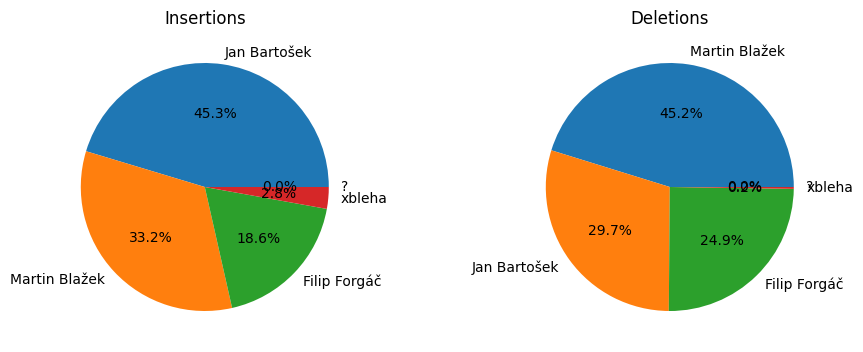

CPU times: total: 78.1 ms
Wall time: 88.9 ms


In [55]:
%%time
mura.insertions_deletions_info(insertions_deletions, config)

<a id='commit-graph'></a>
## Commit graph [↩](#toc)
Displays a graph of the commits in the repository.

The x axis is the time axis. The y axis is the number of commits. Each dot in the graph represents a commit. The color of the dot represents the author of the commit.

The range of the x-axis is computed from the starting commit date and the ending commit date.
To display only a section of the graph, the list can be sliced. This is generally useful to filter out commits at the boundaries. Taking a section in the middle does not make much sense.

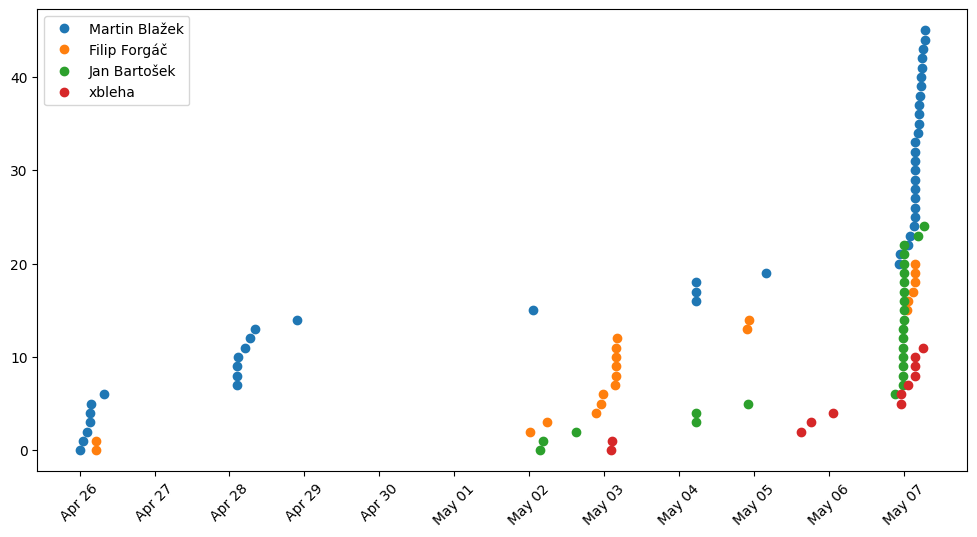

CPU times: total: 109 ms
Wall time: 212 ms


In [56]:
%%time
commits = [commit for commit in commit_range]

commits = commits[1:]  # remove first commit
# commits = commits[:10] # remove last 10 commits

mura.plot_commits(commits, commit_range, contributors, config, force_x_axis_dense_labels=False)

<a id='file-stats'></a>
## File statistics [↩](#toc)
First part of the output is a combined statistics of all file changes in the repository.

- A: Files Added
- D: Files Deleted
- M: Files Modified
- R: Files Renamed

The statistics are cumulative. Meaning if a file is added and in any subsequent commit it is deleted, the file is counted towards both statistics.

In [57]:
%%time
flagged_files = mura.display_file_statistics_info(commit_range, contributors)

👨‍💻 Martin Blažek <xblazek2@fi.muni.cz> (['Martin Blazek <xblazek2@fi.muni.cz> ([])']))
 => A - 95
 => R - 28
 => D - 32
 => M - 189
👨‍💻 Filip Forgáč <xforgac@fi.muni.cz> (['Filip Forgac <xforgac@fi.muni.cz> ([])']))
 => A - 47
 => R - 32
 => D - 6
 => M - 90
👨‍💻 Jan Bartošek <xbartos6@fi.muni.cz> (['Jan Bartosek <xbartos6@fi.muni.cz> ([])', 'jba <jan.bartosek@artisys.aero> ([])']))
 => A - 128
 => R - 2
 => D - 24
 => M - 246
👨‍💻 xbleha <xbleha@fi.muni.cz> (['xbleha <xbleha@fi.muni.cz> ([])']))
 => A - 7
 => R - 0
 => D - 0
 => M - 17
CPU times: total: 78.1 ms
Wall time: 4.04 s


<a id='percentage-ownership'></a>
## Percentages and ownership [↩](#toc)

The following code block displays the percentage of ownership of each contributor. The percentage is computed based on the number of lines of code contributed by the contributor. The percentage is computed for each file and then summed up for each contributor.

The first output shows the total share of code across the project.
Then the individual files are listed.

In [58]:
%%time
percentage, ownership = mura.display_percentage_info(history_analysis_result, contributors, config, repository)

📊 Percentage of tracked files:

	Jan Bartošek <xbartos6@fi.muni.cz> (['Jan Bartosek <xbartos6@fi.muni.cz> ([])', 'jba <jan.bartosek@artisys.aero> ([])']): 19.37%
	Martin Blažek <xblazek2@fi.muni.cz> (['Martin Blazek <xblazek2@fi.muni.cz> ([])']): 35.26%
	xbleha <xbleha@fi.muni.cz> (['xbleha <xbleha@fi.muni.cz> ([])']): 18.69%
	Filip Forgáč <xforgac@fi.muni.cz> (['Filip Forgac <xforgac@fi.muni.cz> ([])']): 25.45%
Files owned by 👨‍💻 Jan Bartošek
	course\src\main\java\cz\muni\fi\pa165\langschool\course\service\CourseService.java (1)
	course\src\main\java\cz\muni\fi\pa165\langschool\course\service\LanguageService.java (1)
	course\src\main\java\cz\muni\fi\pa165\langschool\course\service\ProficiencyService.java (1)
	course\pom.xml (1)
	course\src\main\java\cz\muni\fi\pa165\langschool\course\data\repository\CourseRepository.java (1)
	course\src\main\java\cz\muni\fi\pa165\langschool\course\data\repository\LanguageRepository.java (1)
	course\src\main\java\cz\muni\fi\pa165\langschool\course\data

<a id='ownership-dir-tree'></a>
## Ownership as a directory tree [↩](#toc)

The above output is not very readable, to offer a nicer view and also show ownership of directories based on their contents, the following code block displays the ownership as a directory tree.

In [59]:
%%time
mura.display_dir_tree(percentage, repository)

📁 Dir Tree with ownership:

├── course 👨‍💻 [Jan Bartošek: 52%, Martin Blažek: 34%, xbleha: 12%]
│   ├── openapi.yaml 👨‍💻 [Jan Bartošek: 68%, Martin Blažek: 32%]
│   ├── src 👨‍💻 [Jan Bartošek: 42%, Martin Blažek: 5%, xbleha: 46%]
│   │   ├── main 👨‍💻 [Jan Bartošek: 80%, Martin Blažek: 7%]
│   │   │   ├── java
│   │   │   │   └── cz
│   │   │   │       └── muni
│   │   │   │           └── fi
│   │   │   │               └── pa165
│   │   │   │                   └── langschool
│   │   │   │                       └── course 👨‍💻 [Jan Bartošek: 93%, Martin Blažek: 7%]
│   │   │   │                           ├── service 👨‍💻 [Jan Bartošek: 96%, Martin Blažek: 4%]
│   │   │   │                           │   ├── CourseService.java 👨‍💻 [Jan Bartošek: 99%, Martin Blažek: 1%]
│   │   │   │                           │   ├── LanguageService.java 👨‍💻 [Jan Bartošek: 95%, Martin Blažek: 5%]
│   │   │   │                           │   └── ProficiencyService.java 👨‍💻 [Jan Bartošek: 95%, Martin Blažek: 5%]


<a id='lines'></a>
## Lines, Blanks and Comments [↩](#toc)

In this section, apart from number of lines, top 5 largest and smallest files are shown, this number exposed as `n_extreme_files`. Setting the value to 0 skips the section about largest/smallest files. The information about comments is taken from the final state of the project.

In [60]:
%%time
mura.display_lines_blanks_comments_info(repository, ownership, semantic_analysis_grouped_result, tracked_files, n_extreme_files=5)

⬛️ Blanks and comments:

📝 Total lines: 5865 across 126 files.
📝 Largest files:
 => lecture\src\test\java\cz\muni\fi\pa165\langschool\lecture\service\LectureServiceTests.java (470) by 👨‍💻: Filip Forgáč
 => lecture\src\main\java\cz\muni\fi\pa165\langschool\lecture\service\LectureService.java (362) by 👨‍💻: None
 => person\src\main\java\cz\muni\fi\pa165\langschool\person\service\PersonService.java (340) by 👨‍💻: xbleha
 => course\src\main\java\cz\muni\fi\pa165\langschool\course\service\CourseService.java (238) by 👨‍💻: Jan Bartošek
 => exercise\src\main\java\cz\muni\fi\pa165\langschool\exercise\service\ExerciseService.java (228) by 👨‍💻: None
📝 Smallest files:
 => utils\src\main\java\cz\muni\fi\pa165\langschool\utils\Errors.java (9) by 👨‍💻: Filip Forgáč
 => person\src\main\java\cz\muni\fi\pa165\langschool\person\data\repository\PersonRepository.java (11) by 👨‍💻: xbleha
 => person\src\main\java\cz\muni\fi\pa165\langschool\person\client\LanguageClient.java (11) by 👨‍💻: xbleha
 => exercise\src\

<a id='unmerged-commits'></a>
## Unmerged commits [↩](#toc)

This section analyzes branches that exist in the repository between the `start` and `end` commit but were not merged into the main branch.

In [61]:
%%time
commit_range.display_unmerged_commits_info(repository, config, contributors)


⚠️ Unmerged branch: origin/person-integration-tests
726beeb012f72c226719aa9e86516cbbb6be5115 (⬆️ Commit: person tests by 'Jan Bartošek')
                   ⬇️                   
c6a5b2360d3f502844bfa4db5d9e9ee5c3e8e7a8 (⬆️ Commit: Change runnable scenario instructions formatting by 'Martin Blažek')

⚠️ Unmerged branch: origin/review/xhazdra/m2
1c847c053be30581745eb3c4ee36d4e2e7f8b3dd (⬆️ Commit: Draft 4 by '?')
                   ⬇️                   
2c054ea65486e1a1b3a1630855713d23067683c2 (⬆️ Commit: Draft 3 by '?')
                   ⬇️                   
7b8f6d34635c19bbc1d72872295a04bd846a01e9 (⬆️ Commit: Draft 2 by '?')
                   ⬇️                   
d1a83ad8942e5d412929f8fbccedade3dc1a8466 (⬆️ Commit: Draft 1 by '?')
                   ⬇️                   
e1aa62cdea455469929c10da53bcfae6f06ba258 (⬆️ Commit: Merge branch 'course-persistence' into 'main' by 'Martin Blažek')

⚠️ Unmerged branch: origin/security
ff9ce5ff68de2d82abc1490a073da2cced2b018d (⬆️ Commit: [WIP

<a id='sonarqube'></a>
## Issues and Hotspots using SonarQube [↩](#toc)

Apart from inspection performed by the tool itself, outputs from SonarQube are also available. The analysis is done in a Docker container in the steps above. The code block below will wait until the analysis is done and then query SonarQube for the results. It should not be possible now, but if no issues are reported while "Running All" and the container successfully finished, re-run this and the summary cell, to obtain the data correctly. The web interface can be accessed as well to view further results not used by Mura.

In [62]:
%%time
syntactic_weights = mura.display_sonar_info(config, contributors, repository, ownership, project_key)

📖 Syntax + Semantics using SonarQube:

📝 Syntax analysis uses SonarQube and 'config.use_sonarqube = False'. Skipping syntax analysis.
CPU times: total: 15.6 ms
Wall time: 1.24 ms


<a id='local-syntax'></a>
## Local Syntax + Semantics analysis [↩](#toc)

The semantic info call uses the built-in analyzers to obtain information about code constructs for each analyzed file. The results are grouped by folders.

In [63]:
%%time
local_syntax_weights = mura.display_local_syntax_info(config, ownership, syntactic_analysis_result, repository, file_history_multiplier)

📖 Local Syntax Analysis

📝 Base file weight: 5.0
 - common\src\main\java\cz\muni\fi\pa165\langschool\common\seeder\DataSeeder.java -> 🏆 Weight: 4.391304347826088 adjusted *(1.0)
 - common\src\main\java\cz\muni\fi\pa165\langschool\common\service\CommonService.java -> 🏆 Weight: 3.6818181818181817 adjusted *(0.9)
 - course\src\main\java\cz\muni\fi\pa165\langschool\course\data\model\Course.java -> 🏆 Weight: 4.251724137931035 adjusted *(0.9)
 - course\src\main\java\cz\muni\fi\pa165\langschool\course\data\model\Language.java -> 🏆 Weight: 4.609756097560975 adjusted *(1.0)
 - course\src\main\java\cz\muni\fi\pa165\langschool\course\data\model\Proficiency.java -> 🏆 Weight: 4.217647058823529 adjusted *(0.9)
 - course\src\main\java\cz\muni\fi\pa165\langschool\course\data\repository\CourseRepository.java -> 🏆 Weight: 3.576923076923077 adjusted *(1.0)
 - course\src\main\java\cz\muni\fi\pa165\langschool\course\data\repository\LanguageRepository.java -> 🏆 Weight: 3.8 adjusted *(1.0)
 - course\src\main

In [64]:
%%time
semantic_weights = mura.display_semantic_info(tracked_files, ownership, semantic_analysis_grouped_result, file_history_multiplier)

📚 Semantics:

📦 Group: C:\MUNI\last\Java\M3\pa165_language_school
Total files: 8
🏆 Total weight: 0.0

📦 Group: C:\MUNI\last\Java\M3\pa165_language_school\.mvn\wrapper
Total files: 1
🏆 Total weight: 0.0

📦 Group: C:\MUNI\last\Java\M3\pa165_language_school\common
Total files: 5
🏆 Total weight: 0.0

📦 Group: C:\MUNI\last\Java\M3\pa165_language_school\common\src\main\java\cz\muni\fi\pa165\langschool\common\seeder
Total files: 1
File: DataSeeder.java: Owner: Filip Forgáč
Contents: Classes: 1 Functions: 2 Properties: 0 Fields: 2 Comments: 0 
🏆 Semantic file weight: 16.8 adjusted *(1.0)
🏆 Total weight: 16.8

📦 Group: C:\MUNI\last\Java\M3\pa165_language_school\common\src\main\java\cz\muni\fi\pa165\langschool\common\service
Total files: 1
File: CommonService.java: Owner: Filip Forgáč
Contents: Classes: 1 Functions: 2 Properties: 0 Fields: 0 Comments: 0 
🏆 Semantic file weight: 14.940000000000001 adjusted *(0.9)
🏆 Total weight: 14.940000000000001

📦 Group: C:\MUNI\last\Java\M3\pa165_language_sch

<a id='constructs'></a>
## Constructs and ownership [↩](#toc)

The following code block summarizes the data obtained in the previous step into a more readable format. Discarding details and presenting counts of constructs owned by a contributor.

In [65]:
%%time
mura.display_constructs_info(tracked_files, ownership, semantic_analysis_grouped_result)

📚 Constructs:

👨‍💻 Filip Forgáč
  Owns:
   => class - 9
   => field - 18
   => function - 40
   => comment - 3
👨‍💻 Jan Bartošek
  Owns:
   => function - 53
   => class - 6
   => field - 20
   => comment - 2
👨‍💻 xbleha
  Owns:
   => class - 13
   => field - 38
   => comment - 5
   => function - 92
👨‍💻 Martin Blažek
  Owns:
   => class - 20
   => field - 61
   => function - 145
CPU times: total: 15.6 ms
Wall time: 2.01 ms


<a id='hour-estimation'></a>
## Hour estimation [↩](#toc)

Hour estimation in based on the tool git-hours available [here](https://github.com/kimmobrunfeldt/git-hours). The algorithm was written into python to remove the need to install npm and all complete all the necessary steps. The estimated hours are then used to compute weights for each contributor based on normal distribution.

In [66]:
%%time
hour_estimates = mura.display_hour_estimates(contributors, repository)

hour_weights = mura.gaussian_weights(config, hour_estimate_per_contributor, hour_estimates)

⏱ Hour estimates:

👨‍💻 Martin Blažek has:
 => 94 commits
 => ⏱ ~64 hours of work
👨‍💻 Filip Forgáč has:
 => 38 commits
 => ⏱ ~38 hours of work
👨‍💻 Jan Bartošek has:
 => 59 commits
 => ⏱ ~47 hours of work
👨‍💻 xbleha has:
 => 27 commits
 => ⏱ ~27 hours of work

🏆 Gaussian weights:

👨‍💻 Martin Blažek:
 => 8.79 🏆 Weight gained for: 64 hours of work.
👨‍💻 Filip Forgáč:
 => 104.96 🏆 Weight gained for: 38 hours of work.
👨‍💻 Jan Bartošek:
 => 48.98 🏆 Weight gained for: 47 hours of work.
👨‍💻 xbleha:
 => 191.84 🏆 Weight gained for: 27 hours of work.
CPU times: total: 0 ns
Wall time: 54.9 ms


<a id='remote-repo'></a>
## Remote repository [↩](#toc)

Apart from code, Mura also analyzes the remote repository is instructed to do so. The following code block displays the number of issues and pull requests. Each "remote object" in participating in the weight computation. Complex pull requests and stale pull requests are penalized. Merging pull requests as self without code review is also penalized.

In [67]:
%%time
remote_project, repo_management_weights = mura.display_remote_info(commit_range, repository, config, contributors)

🌐 Remote repository management:

Project: PA165_Language_School
📋 Total issues: 0
🔄 Total pull requests: 28
👨‍💻 Total contributors: 5
📝 All of the presented information were extracted from https://gitlab.fi.muni.cz/xbartos6/pa165_language_school.
📝 Checking for issues and pull requests between 2023-04-16 23:59:06+02:00 and 2023-05-07 23:59:59.999999+02:00.


🔄 Pull request: Fix CourseServiceTests - by Martin Blažek

From: course-tests-m3 to main
Link: https://gitlab.fi.muni.cz/xbartos6/pa165_language_school/-/merge_requests/45
Description: 
Merged at: 2023-05-07 23:39:53.123000+02:00 by Martin Blažek
⚠️ PR Fix CourseServiceTests was merged by the author and has no reviewers!
🏆 Weight 0.0 - Beneficiaries: Martin Blažek


🔄 Pull request: merge Person-module-fix into main - by Jan Bartošek

From: person-module-fix to main
Link: https://gitlab.fi.muni.cz/xbartos6/pa165_language_school/-/merge_requests/44
Description: 
Merged at: 2023-05-07 23:41:04.381000+02:00 by Martin Blažek
⚠️ PR merge

<a id='rules'></a>
## Rules [↩](#toc)

Rules are an easy way to assert file ownership. Rules are defined in the configuration file mentioned above.

In [68]:
%%time
rule_violation_weight_multipliers = mura.display_rule_info(config, repository, ownership, contributors, remote_project)

📜 Rules: 

All contributors must have at least 1 file/s matching: `.*Controller.*\.java` in a directory matching: `*`
All contributors must have at least 1 file/s matching: `.*Test.*\.java` in a directory matching: `*`
All contributors must have at least 1 file/s matching: `pom\.xml` in a directory matching: `*`
All contributors must have at least 1 authored pull request/s.
All contributors must have at least 1 authored issue/s.

🏆 Weight Multipliers:
	File weight 0.9
	Issue weight 0.98
	Pull request weight 0.9

🚫 Violated Rules: 

❌ 👨‍💻 Contributor: 'Jan Bartošek' did not fulfill the following requirements:
	All contributors must have at least 1 file/s matching: `.*Controller.*\.java` in a directory matching: `*`
❌ 👨‍💻 Contributor: 'xbleha' did not fulfill the following requirements:
	All contributors must have at least 1 file/s matching: `.*Controller.*\.java` in a directory matching: `*`
	All contributors must have at least 1 file/s matching: `pom\.xml` in a directory matching: `*`


<a id='summary'></a>
## Summary [↩](#toc)

Summarizes the data collected in the steps above and displays the final weights for each contributor. Higher weights mean the contributor was more active during the development process. When comparing complexity of two projects the absolute weight can be used to measure complexity between the two projects. Within the project the relative distribution between the contributors can be used to identify stronger and weaker members of the team.

In [69]:
%%time
mura.display_summary_info(contributors, syntactic_weights, semantic_weights, local_syntax_weights, repo_management_weights,
                  rule_violation_weight_multipliers, hour_weights, file_history_multiplier)



🏆 Total weight per contributor for 🔲 SonarQube analysis:
📝 These weights are negative, that is intentional, as the analysis goes though the issues and security concerns.
📝 Nothing to show here...


🏆 Total weight per contributor for 📚 Semantics:
 -> Martin Blažek: 378.30
 -> Filip Forgáč: 152.44
 -> Jan Bartošek: 172.10
 -> xbleha: 262.70


🏆 Total weight per contributor for 📖 Syntax:
 -> Martin Blažek: 82.51
 -> Filip Forgáč: 37.77
 -> Jan Bartošek: 34.71
 -> xbleha: 47.51


🏆 Total weight per contributor for 🌐 Remote repository management:
 -> Martin Blažek: 436.00
 -> Filip Forgáč: 108.00
 -> Jan Bartošek: 388.00


🏆 Total weight per contributor for ⏱ Estimated hours:
 -> Martin Blažek: 8.79
 -> Filip Forgáč: 104.96
 -> Jan Bartošek: 48.98
 -> xbleha: 191.84


🏆⚠️ Weight multiplier for unfulfilled 📜 Rules:
 -> Martin Blažek: 0.79
 -> Filip Forgáč: 0.88
 -> Jan Bartošek: 0.88
 -> xbleha: 0.71


🏆 Total weight per contributor:
1️⃣ -> Martin Blažek: 718.86
2️⃣ -> Jan Bartošek: 567.82